In [1]:
"""
This version of cosmoRate is equipped with a full galaxy treatment.
It takes as intput the samples of galactic SFR and logZ obtained
by running cosmo_model_hybrid_v2.ipynb and catalogs of merging compact binaries.
Details follow.
"""
from scipy import interpolate
from random import gauss
from astropy.cosmology import z_at_value
import bisect
import random
import matplotlib.pyplot as plt
from scipy.special import erf
import sys
import astropy.units as u
from astropy.cosmology import Planck15 as Planck
import numpy as np
import os
import scipy.sparse as spr
os.environ['MKL_NUM_THREADS'] = '1' # this command prevents Python from multithreading 
import time
import matplotlib.patches as pat
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.ticker import (Locator, LogLocator, MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from matplotlib import ticker, cm
import pandas as pd
from tqdm import tqdm
import h5py

In [2]:
def mid_creator(bin_array):
    # this function takes as input a set of bin edges (ascending order)
    # and returns as output as array of the mid values
    bin_mid = bin_array[0:len(bin_array)-1]+\
        (bin_array[1:len(bin_array)]-bin_array[0:len(bin_array)-1])/2
    return bin_mid

In [3]:
"""
MERGING COMPACT BINARY FUNCTIONS
This part contains the functions
that handles the catalogs of merging compact binaries, 
for example while the interpolation of the merger efficiency is on
"""
def eta_interpol(Z_missing, Z_simulated, eta_known):
    """
    This function provides the merger efficiency interpolation
    ---------------
    Z_missing --> list of metallicities on which the interpolation is to be performed
    Z_simulated --> list of metallicity that has been used in the simulation
    eta_known --> merger efficiency that is evaluated in cosmo_rate.py, with the data provided by the simulations
    ---------------
    """
    # interpolation of the merging efficiency on the provided values
    eta_unknown_log = np.interp(
        np.log10(Z_missing), np.log10(Z_simulated), np.log10(eta_known))
    eta_unknown = 10**(eta_unknown_log)
    Z_list_us = np.concatenate((Z_simulated, Z_missing))
    Z_list = np.sort(Z_list_us)
    Z_list_index = np.argsort(Z_list_us)
    eta_us = np.concatenate((eta_known, eta_unknown))
    eta = [eta_us[Z_list_index[i]] for i in range(len(Z_list_index))]
    return eta, Z_list

def sort_catalogues(Z_list, Z_simulated, td_Z_sim, data_Z_sim):
    """
    This function provides the delay time and data arrays once the
    eta_interpolation.py has been launched
    --------------
    Z_list --> list of all metallicities, both missing and simulated (see above function)
    Z_simulated --> list of simulated metalicity only
    td_Z_sim --> time delays of simulated compact binaries.
    data_Z_sim --> all other consider parameters of simulated compact binaries
    --------------
    """
    td_Z = np.zeros((len(Z_list)), dtype=np.ndarray)
    data_Z = np.zeros((len(Z_list)), dtype=np.ndarray)
    index = np.zeros((len(Z_list)))

    Z_list = Z_list.tolist()

    for i in range(len(Z_list)):
        err = 100.
        if Z_list[i] <= 0.002:
            for met in Z_simulated:
                if err > np.abs(Z_list[i] - met):
                    err = np.abs(Z_list[i] - met)
                    index[i] = Z_simulated.index(met)
        else:
            index[i] = Z_simulated.index(0.02)

    index = [int(index[y]) for y in range(len(index))]
    td_Z = [td_Z_sim[index[y]] for y in range(len(Z_list))]
    data_Z = [data_Z_sim[index[y]] for y in range(len(Z_list))]

    return td_Z, data_Z


In [4]:
"""
In this part we set up some simulations specificities (for example the origin of the 
compact binary catalogs PopSynth / N-body)
"""
cb_class = 'BBHs'  #compact objects type
# when exported in a python scritp is going to be  sys.argv[1]

termin = '.txt'

# list of metallicity used from simulations, as float type, ascending order
Z_simulated = [0.0002, 0.0004, 0.0008,0.0012, 0.0016, 0.002, 0.004, 0.006, 
               0.008, 0.012, 0.016, 0.02]

# merging efficiency interpolation option
# if 'Yes' the code evaluates the MRD using the merging efficiency interpolated from Z_simulated on Z_interpol
eta_interpol_c = 'No'
# values of metallicity on which the code performs merging efficiency interpolation, as float, ascending order
Z_interpol = [0.0008, 0.008, 0.016]

formation_channel = 'iso'  # formation channel type (iso,dyn)
if formation_channel == 'iso':
    fbin = 0.5  # fraction of binaries, for 'iso' it must be either 50% or 40%. 
                #40% when you comapare the isolated and dynamical formation channel
    #fbin = 1 # for referenceB model 
    fimf = 0.285 # correction for initial mass function. For 'iso' must be 0.285.
    #fimf = 1 # for referenceB model 
    fbin_save = int(100.0*fbin)# this is the fraction of binaries that appears in the file name.
elif formation_channel == "dyn":
    fbin = 1.  # Dynamical binaries are alredy 40% of binaries. 
                # This parameter must be equal to 1
    fimf = 1.  # Dynamical binaries simulated the whole initial mass function. 
                # This parameter must be equal to 1
    fbin_save = 40  # this is the fraction of binaries that appears in the file name.
                # Dynamical binaries are alredy 40 % of binaries, as stated above


In [5]:
"""
Description of the input merging compact binary catalogues:
The code will search in input_catalogues/ folder files .dat
divided per each compact binary type and per each Z.
The files must contain in the first colum the delay time in YEARS.
All other columns contain other binary parameters. More details below.
The first row of each file containes the total simulated mass.
"""

n_paral = 0 # value to be assigned in order to paralelize the code and not to overwrite oder output

astro_mod = 'A5/'

folder_in = '../astro_models/'+astro_mod 


In [6]:
# the default option is to use a comoving volume constant and change the number density of galaxies
# this is the faste option
eval_mode = 'Vconst' #or 'Nconst'

In [7]:
# I want to load EAGLE catalogs 
custom_catalogs = False
if custom_catalogs == True:
    folder_out = '../Models/M_EAGLE'
    folder_all =folder_out +'/Tables/'
    # Redshift bin edges.
    z_hist = np.loadtxt(folder_all+'Redshift_bins_edges.txt')
    # array of redshift in descending order
    z_mid = np.loadtxt(folder_all+'Redshift_z_mid.txt')

In [8]:
if custom_catalogs == False:
    
    df = pd.read_csv('../galaxy_models/galaxy_models_list.csv', header = 0)

    # synthetic Universe
    bin_type = 'Equal_z_bins'
    z_a_min = 0
    z_a_max = 8
    Nz = 50

    mass_gal_min = 7
    mass_gal_max = 12
    Ngal = 1000
    GSMF_type = 'Chruslinska_2019'

    Nsample = 1000

    SFMR_type = 'Boogaard_2018'
    Ams = 0.97
    Asb = '1-Ams'
    sb_shift = 0.59
    sigma_ms = 0.188
    sigma_sb = 0.243

    met_scaling_rel = 'Mannucci_2011'
    Z_spread_met_scaling_rel = 0.15
    solar_Z_scale = 'Caffau_11'
    
    
    #passive galaxies parameters
    # Passive galaxies 
    SFR_min_pass = 0.0001 # 'least_SF_EAGLE' or '1e-3'
    SFR_max_pass = 'MS_3sigma' # 'least_SF_MS' or 'MS_2sigma' or 'MS_3sigma'
    SFR_dist = 'uniform' # no other option available 

    # I generally choose Ilbert+2013 because it has a larger redshift span
    passive_GSMF_type = 'Ilbert' # Ilbert gets to larger redshifts

    IMF = 'Kroupa_01'
    
    params = [bin_type, z_a_min, z_a_max, Nz, mass_gal_min, mass_gal_max, 
            Ngal, GSMF_type, Nsample, SFMR_type , Ams,  Asb, sb_shift, 
             sigma_ms, sigma_sb, met_scaling_rel ,Z_spread_met_scaling_rel, solar_Z_scale,
             SFR_min_pass, SFR_max_pass, SFR_dist, passive_GSMF_type, IMF]


    #print('first rows = ', df.head())

    variables = df.keys()
    print(variables)

    #print('variable names = ', variables)

    num_of_cases = len(df[variables[0]])

    print('number of cases = ',num_of_cases )


    b = 0
    for y in range(num_of_cases):
        if b == 0:
            index = y+1
            summing = 0
            print('y = ', y+1)
            #print('    ',' all ', '   this case')
            for i in range(len(params)):
                #print('    ',df[variables[i+1]][y], params[i])
                if df[variables[i+1]][y] == params[i]:
                    summing = summing + 1
                    #print(summing)
                if summing == len(params):
                    print('        found index ! = M',index)
                    b = 1 
                    break
            if (b == 0) and (y == num_of_cases-1):
                print('no index found')
                index = 'NaN'
        elif b == 1:
            break

    folder_out = '../galaxy_models/M'+str(index)

    folder_all =folder_out +'/Tables/'
    
    # Redshift bin edges.
    z_hist = np.loadtxt(folder_all+'Redshift_bins_edges.txt')
    z_mid = mid_creator(z_hist)


Index(['ID', 'bin_type ', 'z_a_min ', 'z_a_max ', 'Nz    ',
       'log_mass_gal_min ', 'log_mass_gal_max  ', 'Ngal ', 'GSMF_type',
       ' Nsample   ', ' SFMR_type', 'Ams', ' Asb ', '  sb_shift  ',
       'sigma_ms    ', 'sigma_sb  ', 'met_rel_type   ', 'Z_spread_met_rel ',
       'solar_Z_scale ', 'SFR_min_passive', 'SFR_max_passive',
       'SFR_dist_passive', 'GSMF_pass', 'IMF'],
      dtype='object')
number of cases =  1
y =  1
        found index ! = M 1


In [9]:
"""
All cosmological quantities are read in this part
"""#print(z_hist)

# Sampled quantities
Mass_galaxies =  np.loadtxt(folder_all+'logM.txt') 
    # It is not directly used to caluclate the MRD
Mass_min = np.amin(Mass_galaxies, axis = None)
print('Mass min = ', Mass_min)
SFR_galaxies =  10**np.loadtxt(folder_all+'logSFR.txt') # It must be in linear scale
Z_m_galaxies =  np.loadtxt(folder_all+'logZ.txt')
    # It must be in log(Z)
dN_dV = np.loadtxt(folder_all+'dN_dV.txt', usecols = 1)
    # This gives the number of galaxies per unit volume
    
print('Number of redshift bins = ',len(Z_m_galaxies[:,0]))
print('Fixed Number of sampled galaxies per redshift bin = ',len(Z_m_galaxies[0,:]))
N_galaxies = len(Z_m_galaxies[0,:])

# number of samples per each redshift bin such way we can consider a unique comoving volume
dN_dV_max = np.max(dN_dV)
N_sample_z = N_galaxies/dN_dV_max*dN_dV
print('Number of sampled galaxies per each redshift bin = \n (redshift in descending order) \n',
      N_sample_z)

# metallicity spread per each galaxy, explore more on this
sigma_galaxies = 0.14

Mass min =  7.00251280399968
Number of redshift bins =  49
Fixed Number of sampled galaxies per redshift bin =  1000
Number of sampled galaxies per each redshift bin = 
 (redshift in descending order) 
 [   5.00933005    9.78921664   14.56828149   19.34925132   24.13193769
   28.81184936   33.18034182   36.6003642    40.02526775   43.45449611
   46.8801489    50.28729489   53.70907025   57.13181444   60.55361771
   63.9756403    67.40213947   70.83490382   78.56386145   90.84958586
  106.39119922  122.34027301  138.64184926  155.08140433  171.50723966
  187.73414737  203.54663252  220.74363466  246.20607381  273.54952858
  299.41779503  323.59197376  338.66008658  345.49314451  348.19159573
  363.37356711  420.02555428  476.32874607  512.76732759  531.37003168
  546.98430497  586.82157315  688.85330911  755.19888889  797.01407547
  832.31468336  885.75343903  949.30397496 1000.        ]


In [10]:
# check if the folder exist, otherwise create it 
check_folder = os.path.isdir(folder_out+'/'+astro_mod)#+obj+'/'+snapshot)
if check_folder == False:
    print('creating folder')
    os.mkdir(folder_out+'/'+astro_mod)
    
check_folder = os.path.isdir(folder_out+'/'+astro_mod+'MRD/')#+obj+'/'+snapshot)
if check_folder == False:
    print('creating folder')
    os.mkdir(folder_out+'/'+astro_mod+'/MRD/')
    
check_folder = os.path.isdir(folder_out+'/'+astro_mod+'MRD/'+cb_class)#+obj+'/'+snapshot)
if check_folder == False:
    print('creating folder')
    os.mkdir(folder_out+'/'+astro_mod+'/MRD/'+cb_class)

In [11]:
# location of where the output file are going to be saved
location = folder_out+'/'+astro_mod+'MRD/'

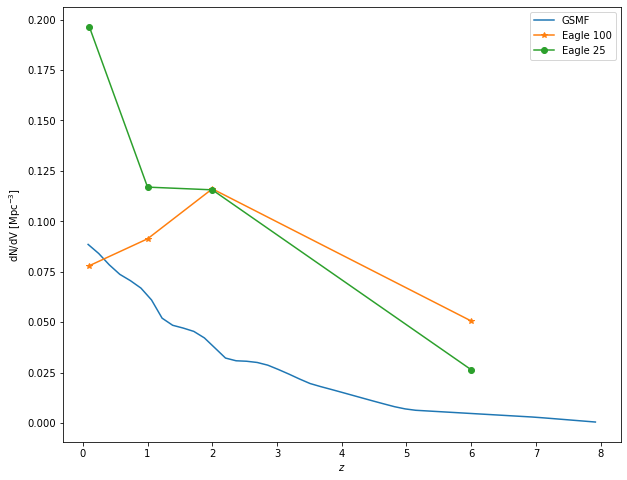

In [12]:
# let's compare the galaxy number density of GSMF and Eagle 
# from Celeste et al. 2019 paper
# I adopted the same mass range logM \in [7, 12]
dN_dV_Eagle_100 = np.array([77959, 91294, 116074, 50544])/(100**3)
dN_dV_Eagle_25 = np.array([3070,1827, 1806,412])/(25**3)
z_Eagle = [0.1, 1, 2, 6]

plt.close()
plt.figure(figsize = (10,8))
#plt.plot(z_hist[0:len(z_hist)-1], dN_dV, label = 'GSMF')
plt.plot(z_mid, dN_dV, label = 'GSMF')
plt.plot(z_Eagle, dN_dV_Eagle_100, label = 'Eagle 100', marker = '*')
plt.plot(z_Eagle, dN_dV_Eagle_25, label = 'Eagle 25', marker = 'o')
#plt.yscale('log')
#plt.xscale('log')
plt.xlabel(r'$z$')
plt.ylabel('dN/dV [Mpc$^{-3}$]')
plt.legend()
plt.savefig(location+'dN_dV_comp.pdf', format = 'pdf')
plt.show()

In [13]:
# this part is ignored in this version
parameters = ['M1', 'M2']
mrd_eval = 'Yes'

In [14]:
"""
What follows is the main script of cosmoRate. 
"""
print(cb_class, astro_mod)
# read the input catalogues by intializing the variables
td_Z_sim = []
data_Z_sim = []
mtot_Z_sim = []
# read time delays and other parameters from catalogues
for Z_sim in Z_simulated:
    data_Z_read = np.loadtxt(
        folder_in+'input_catalogues/data_'+cb_class+'_'+str(Z_sim)+termin, skiprows=1)
    data_Z_sim.append(data_Z_read[:, 1:len(parameters)+1])
    td_Z_sim.append(data_Z_read[:, 0])
    mtot_is_0 = np.loadtxt(folder_in+'input_catalogues/data_' +
                           cb_class+'_'+str(Z_sim)+termin, usecols=0)
    mtot_Z_sim.append(mtot_is_0[0])

# compute merger efficiency. The binary fraction (fbin) and the IMF parameter (fimf) 
# need to be specified in the input file
eta_known = [np.array(len(td_Z_sim[q]))/np.array(mtot_Z_sim[q])*fbin*fimf 
             for q in range(len(td_Z_sim))]
#print('merger efficiency = \n', eta_known)

BBHs A5/


In [15]:
# if option activated, use an interpolation on missing metallicities
if eta_interpol_c == 'Yes':
    [eta, Z_list] = eta_interpol(Z_interpol, Z_simulated, eta_known)

    [td_Z, data_Z] = sort_catalogues(
        Z_list, Z_simulated, td_Z_sim, data_Z_sim)
else:
    eta = eta_known
    Z_list = Z_simulated
    td_Z = td_Z_sim
    data_Z = data_Z_sim

# logZ min e logZ max, I add some orders of magnitude to be sure such way the normalization of the gaussian
# distribution is always equal to one, in any case a consistency check is made at each iteration
Z_max = np.amax(Z_m_galaxies, axis = None)+3
print('max Z = ', Z_max)
Z_min = np.amin(Z_m_galaxies, axis = None)-3
print('min Z = ', Z_min)
# Z_list is transformed in log scale
Z_log = np.log10(Z_list)
Z_bins = np.concatenate([Z_min, Z_log, Z_max],axis = None)
Z_prob = np.zeros(len(Z_log)+1)
for p in range(len(Z_prob)):
    Z_prob[p] = Z_bins[p]+(Z_bins[p+1]-Z_bins[p])/2

print('Z prob = ', Z_prob)
print('Z list = ', np.log10(Z_list))
#print('logZ bin edges for probability = ', Z_prob)

max Z =  1.8779401117911232
min Z =  -6.603911961552068
Z prob =  [-5.15144098 -3.54845501 -3.24742501 -3.00886438 -2.85834939 -2.74742501
 -2.54845501 -2.30989438 -2.15937938 -2.00886438 -1.85834939 -1.74742501
  0.08948505]
Z list =  [-3.69897    -3.39794001 -3.09691001 -2.92081875 -2.79588002 -2.69897
 -2.39794001 -2.22184875 -2.09691001 -1.92081875 -1.79588002 -1.69897   ]


In [16]:
filename = '/Matrix_v_'+str(len(Z_list))+'Z_'+str(fbin_save)+'_'+ \
    eta_interpol_c+'_'+str(sigma_galaxies)+ \
    '_'+str(n_paral)+'.h5'

In [17]:
# printing the delta time 
# array of time in ascending order
bin_t = np.array(sorted(Planck.lookback_time(z_hist).value*1e09))  # in yrs using Planck15
#print(bin_t)
Delta_t = bin_t[1:]-bin_t[0:-1]
#print('Delta t = \n', Delta_t)

In [18]:
"""
Now we are going to evaluate the quantity v which is the number of mergers per 
galaxy and it depends on merger redshift, formation redshift
and metallicity
"""

# array of time in ascending order
bin_t = np.array(sorted(Planck.lookback_time(z_hist).value*1e09))  # in yrs using Planck15

# now I am saving on a hdf5 file to save memory space
hf = h5py.File(location+cb_class+'/'+filename, 'w')


# loop over formation redshift
t00 = time.time()
ind_m_z_list = []
print('evaluating the MRD')
for i in tqdm(range(len(z_mid))):   
    
    v = np.zeros((len(z_mid), 1, len(Z_prob)-1, N_galaxies))
    
    t_form = Planck.lookback_time(z_mid[i]).value*10**9
    dt = bin_t[len(z_mid)-1-i+1]-bin_t[len(z_mid)-1-i]

    
    if eval_mode == 'Vconst':
        # selecting a subsample of galaxies 
        len_m_z = int(N_sample_z[i]) # number of samples
        # without reptetitions
        ind_m_z=[] # list of samples
        array_of_galaxies = np.arange(0,N_galaxies)
        while len(ind_m_z) < len_m_z:
            r_samp=np.random.choice(array_of_galaxies)
            #if r_samp not in ind_m_z: 
            ind_m_z.append(r_samp)
            array_of_galaxies = np.delete(array_of_galaxies, 
                                np.nonzero(array_of_galaxies==r_samp)[0])
                    
        # I need to sort them again
        ind_m_z_list.append(np.sort(ind_m_z))
        
    elif eval_mode == 'Nconst':
        ind_m_z = np.arange(0,N_galaxies,1)
            
    for m in ind_m_z:
        
        SFR = SFR_galaxies[i,m] #Msun/yr
        Mdens = dt*SFR  # Msun 
        ###print('formed stellar log mass ', np.log10(Mdens))
        
        # average metallicity per each galaxy, it is given in logZ   
        mu = Z_m_galaxies[i,m]
        # compute the probability distribution of each metallicity per each galaxy
        xA = Z_prob[0:len(Z_prob)-1]
        probA = 0.5*(1+erf((xA - mu)/(sigma_galaxies*(2**0.5))))
        xB = Z_prob[1:len(Z_prob)]
        probB = 0.5*(1+erf((xB - mu)/(sigma_galaxies*(2**0.5))))
        prob = probB-probA
        ###print('prob = ', prob)
        if abs(sum(prob) - 1) > 1e-01:
            print('sum of all probabilities = ',
                sum(prob), 'at formation z = ', z_mid[i], 'and mass index = ', m)
            break

        # loop over each metallicity
        for y in range(len(Z_prob)-1):
            tdm = td_Z[y]  # Delay time of compact binaries
            ###print(len(td_Z[y]))
            ind_Z = np.random.randint(low = 0, high = len(tdm), 
                                      size = int(prob[y]*len(tdm)))
            ###print(Z_list[y],int(prob[y]*len(tdm)), len(td_Z[y]))
            t_merg = t_form - tdm[ind_Z]  # time of merger yr
            
            vv = np.histogram(t_merg, bins=bin_t)[0]
            """
            This quantity gives us the number of objects merging as a function 
            of 4 variables. The 1st index tracks the merger time bin, the 2nd the
            time bin of formation time and the 3rd the metallicity and the 4th the galaxy
            vv[::-1]/float(len(tdm)) gives the proportion of mergers formed at zf 
            that merges in each zm, by multipyling it with the merger efficiency 
            eta (Msol-1), the probability that the metallicity was m at zf and 
            the mass density at zf, we obtain the density of objects 
            that formed at zf with met Z and merged at zm.
            """   
            v[:, 0, y, m] = vv[::-1]/float(len(tdm))*eta[y]*Mdens #*prob[y]
            
            #v[:, i, y, m] = vv[::-1]/Msim[y]*Mdens*fbin*fimf

    #print(v)
    #print('shape  =', v.shape)
    hf.create_dataset('z_form_'+str(i), data=v)
    
    #t1 = time.time()
    # total = t1-t0
    #print('z_form = ', z_mid[i], ' time = ', total, 'seconds ')
t11 = time.time()
tt = t11-t00
print('total time for ',N_galaxies, ' galaxies = ', tt/60, ' minutes' )

evaluating the MRD


100%|███████████████████████████████████████████| 49/49 [00:54<00:00,  1.11s/it]

total time for  1000  galaxies =  0.9041771014531453  minutes


In [19]:
ind_m_z_list_save = np.array(ind_m_z_list, dtype=object)
ind_max = np.argmax(N_sample_z)

print('maximum number of galaxies = ', len(ind_m_z_list_save[ind_max]), 'at z = ', z_mid[ind_max])
if eval_mode == 'Vconst':
    #print(ind_m_z_list)
    # saving the index at each redhsift as a compressed numpy array 
    filename = '/Sampled_indexes_'+str(len(Z_list))+'Z_'+str(fbin_save)+'_'+ \
    eta_interpol_c+'_'+str(sigma_galaxies)+ \
    '_'+str(n_paral)
    np.savez_compressed(location+cb_class+'/'+filename,ind_m_z_list_save)

maximum number of galaxies =  1000 at z =  0.08163265306122458


In [20]:
# evaluating the MRD
MRD_z_C = np.zeros(len(z_mid))

if eval_mode == 'Vconst':
    V = N_galaxies/dN_dV[ind_max]
    print('Constant volume V = (', pow(V,1/3), 'Mpc)^{3}')
    weights = np.ones(len(z_mid))
elif eval_mode == 'Nconst':
    weights = dN_dV/dN_dV[ind_max]
    
print('evaluating the merger rate density:')
for zb in tqdm(range(len(z_mid))):  
    # sum over formation redshift, metallicities and all galaxies
    rate = 0
    for zm in range(zb+1):
    #for zm in range(len(z_mid)):
        v_sum = np.array(hf.get('z_form_'+str(zm)))
        #print(v_sum.size)
        #print(v_sum)
        rate = rate + np.sum(v_sum[zb, 0, :, :], axis = None)*weights[zm]
    Delta_t = (bin_t[len(z_mid)-zb]-bin_t[len(z_mid)-zb-1])
    #print(zb, Delta_t/1e09)
    ###print('Delta t = ', Delta_t/1e09, ' Gyr')
    MRD_z_C[zb] = rate/Delta_t/V*1e09 # merger rate density in yr^-1 in Gpc^-1     

# Save MRD in output file
head = "Redshift"+"\t\t"+"Merger Rate Density [Gpc^-3 yr^-1]"
filename = '/MRD_averaged_'+str(len(Z_list))+'Z_'+str(fbin_save)+'_'+ \
    eta_interpol_c+'_'+str(sigma_galaxies)+'_'+str(n_paral)+'.txt'

# Column 0: merger redshift, Column 1: Merger Rate Density
MR_z_save = np.zeros((len(z_mid), 2))
for c in range(len(z_mid)):
    MR_z_save[c, :] = np.hstack(
        [z_mid[::-1][c], MRD_z_C[::-1][c]])
np.savetxt(location+cb_class+'/'+filename, MR_z_save, header=head)


Constant volume V = ( 22.438303853966616 Mpc)^{3}
evaluating the merger rate density:


100%|███████████████████████████████████████████| 49/49 [00:04<00:00, 10.71it/s]


In [21]:
hf.close()